In [1]:
# import stand alone packages
import torch
import importlib
import yaml
import pandas as pd
import numpy as np
import torch.distributions as dist
import matplotlib.pyplot as plt
import networkx as nx
from pysmiles import read_smiles
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import importlib
import selfies
import torch.nn.functional as TorchF
import sys
import auxiliary_functions

# import our own functins
import data_loader
import chemistry_vae_symmetric_rnn_final

sys.path.insert(0, '../mlp/')

import properties_searcher_2



*Pipeline steps:*

*VAE:* 

The first step is to simply train a VAE. Ideal hyperparameters are already set up in the 'selfies_rnn.yml' file. The functions within the VAE are fairly generic, i.e., save models, save scores, etc. The VAE is fed datasets in SMILES form, after which it converts the dataset to SELFIES. There is an option to use SMILES however this is redundant and will be removed in the quality of life stuff.

The VAE saves a model every 50 epochs, you should be able to generate a good model after that many epochs. 


*MLP:*

The settings within the perceptron are slightly more confusing. Since the VAE randomises the input dataset, the alphabets are inconsistent and so we have to specifiy the alphabet of the VAE every time. The MLP has generic functions, similar to the VAE. 


*Analysis:*

Our analysis for QM9 involves looking at the validation dataset and seeing if the perceptron is capable of predicting the HOMO-LUMO gaps. I.e., whether the perceptron can figure out the HOMO-LUMO gaps of data unseen by the VAE. 

Furthermore, in this notebook, all of the non-generic functions will be displayed.

Ultimately, we should have a plot that demonstrates how good the perceptron is at predicting the HOMO-LUMO gaps for unseen molecules. This would be analagous to generating some new latent vectors defined by the latent space. However, since QM9 is complete, we cannot really generate any new molecules, hence the benchmark nature of the paper.


Our analysis uses the QM9 data


In [2]:
# in order to train the RNN vae run
# chemistry_vae_symmetric_rnn_final.main()

In [3]:
# here we want to read in data and tranform them into one_hot
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

qm9_path = "../datasets/filtered_qm9_energies.csv"

selfies_list, selfies_alphabet, largest_selfies_len, smiles_list, smiles_alphabet, largest_smiles_len = chemistry_vae_symmetric_rnn_final.get_selfie_and_smiles_encodings_for_dataset(qm9_path)



{'H': 1, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'B': 3, 'B+1': 2, 'B-1': 4, 'O': 2, 'O+1': 3, 'O-1': 1, 'N': 3, 'N+1': 4, 'N-1': 2, 'C': 4, 'C+1': 5, 'C-1': 3, 'P': 5, 'P+1': 6, 'P-1': 4, 'S': 6, 'S+1': 7, 'S-1': 5, '?': 8}
                  smiles  energy_gap
0       N#CC1NC11C2CC1C2      0.2818
1         OC1=NON=C1OC=O      0.2271
2        CC12CCC1CN1CC21      0.3036
3        CN=C1OC(=O)CC1N      0.2451
4         CC(CO)C(CO)C#N      0.3048
...                  ...         ...
130687  CC1CC2(OCC12)C#C      0.2649
130688  CC(=O)C12CCC1CO2      0.2115
130689  CC1(CNC1=O)C1CN1      0.2719
130690  CC1=NC2C3CC2C3O1      0.2617
130691   CCN1C=C(O)N=C1C      0.2227

[130692 rows x 2 columns]
--> Translating SMILES to SELFIES...
27
Finished translating SMILES to SELFIES.


In [4]:
largest_selfies_len

21

***VAE USAGE:***

In [5]:
importlib.reload(auxiliary_functions)

<module 'auxiliary_functions' from '/users/sgccook3/DM_chems/Pipeline/vae/auxiliary_functions.py'>

In [6]:
###Step 0: Decide what data you want to analyse

# 1. For just one SELFIE:
selfie_input = [selfies_list[0]] ### Choose the SELFIE you want

# 2. For all/multiple SELFIES:

#selfie_input = selfie_list[:1000]


In [7]:
###Step 1: Load the VAE encoder and decoder settings

save_path = '../example_models/final_vae/stack_size1neurons_num2048_l_dim64/'
vae_epoch = 250


vae_settings = yaml.safe_load(open(str(save_path) + "settings/" + "settings.yml", "r"))
encoder_parameter = vae_settings['encoder']
decoder_parameter = vae_settings['decoder']
selfies_alphabet = vae_settings['alphabet']
torch_seed = vae_settings['data']['torch_seed']

In [8]:
###Step 2: Create your one hot representation, we use 'selfie_input' here.

### Need to fetch the indices of the rand_perm tensor

data = auxiliary_functions.multiple_selfies_to_onehot(selfies_list, largest_selfies_len, selfies_alphabet)
data = torch.tensor(data, dtype=torch.float).to(device)
torch.manual_seed(torch_seed)
rand_perms = torch.randperm(data.size()[0])
data = data[rand_perms]

### Now we can look at our input selfies:

data = auxiliary_functions.multiple_selfies_to_onehot(selfie_input, largest_selfies_len, selfies_alphabet)
data = torch.tensor(data, dtype=torch.float).to(device)


In [9]:
###Step 3: Initalise the VAE encoder and decoder

encoder_dict_path = str(save_path) + str(vae_epoch) + "/E.pt"
decoder_dict_path = str(save_path) + str(vae_epoch) + "/D.pt"

encoder_dict = torch.load(encoder_dict_path, map_location = 'cpu')
decoder_dict = torch.load(decoder_dict_path, map_location = 'cpu')


vae_encoder = chemistry_vae_symmetric_rnn_final.VAEEncoder(in_dimension=(data.shape[1]*data.shape[2]), **encoder_parameter)
vae_decoder = chemistry_vae_symmetric_rnn_final.VAEDecoder(**decoder_parameter, out_dimension=len(selfies_alphabet))

vae_encoder.load_state_dict(encoder_dict)
vae_decoder.load_state_dict(decoder_dict)

vae_encoder.eval()
vae_decoder.eval()

VAEDecoder(
  (decode_RNN): GRU(64, 512)
  (decode_FC): Sequential(
    (0): Linear(in_features=512, out_features=27, bias=True)
  )
)

In [10]:
###Step 4: Generate the latent vectors

mus = auxiliary_functions.gen_latent_vectors(vae_encoder, data)

In [11]:
###Step 5: Decode the latent vectors

# The outputs will all be in SMILES

# 1. For a single latent point:

final_smiles_list = auxiliary_functions.decode_single_lpoint(vae_decoder, data.shape[1], mus, selfies_alphabet, device)

# 2. For all/multiple latent points:

#final_smiles_list = auxiliary_functions.decode_lpoint(vae_decoder, data.shape[1], mus, selfies_alphabet, device)

In [12]:
print(final_smiles_list)

['N#CC1NC12C3CC2C3']


*Example usage:*

cinnamon

Visual of the chemical itself:


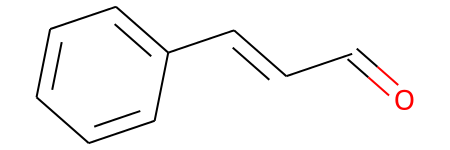

In [13]:
###Step 1: Input your SMILES molecule and convert to a SELFIES

smiles_input = 'C1=CC=C(C=C1)C=CC=O'

selfie_cinnamon = [selfies.encoder(smiles_input)]

molToDraw= Chem.MolFromSmiles(smiles_input)

print('Visual of the chemical itself:')
display(molToDraw)

In [14]:
###Step 2: Convert the molecule to a one hot representation:

data_cinnamon = auxiliary_functions.multiple_selfies_to_onehot(selfie_cinnamon, largest_selfies_len, selfies_alphabet)
data_cinnamon = torch.tensor(data_cinnamon, dtype=torch.float).to(device)

In [15]:
###Step 3: Convert the one hot representation to a latent vector:

cinnamon_lpoint  = auxiliary_functions.gen_latent_vectors(vae_encoder, data_cinnamon)

In [16]:
###Step 4: Decode the cinnamon latent vector

cinnamon_smiles = auxiliary_functions.decode_single_lpoint(vae_decoder, data.shape[1], cinnamon_lpoint, selfies_alphabet, device)

In [17]:
print('cinnamon input:', smiles_input, 'cinnamon recreation:', cinnamon_smiles[0])

cinnamon input: C1=CC=C(C=C1)C=CC=O cinnamon recreation: C1NC=C(C=C1)C(N)=O


In [18]:
importlib.reload(properties_searcher_2)

<module 'properties_searcher_2' from '../mlp/properties_searcher_2.py'>

***MLP:***

In [19]:
# validate perceptron model
mlp_path = '../../VAE_sandbox/perceptron_folder/reworked_mlp/'
mlp_epoch = 50

mlp_settings = yaml.safe_load(open(str(mlp_path) + "settings/" + "settings.yml", "r"))
model_params = mlp_settings['model_params']

mlp = properties_searcher_2.PropertyRegressionModel(**model_params).to(device)
state_dict = torch.load(mlp_path + '/' + str(mlp_epoch) + '/model.pt', map_location='cpu')


mlp.load_state_dict(state_dict)

<All keys matched successfully>

In [20]:
selfies_input = selfies_list[:10000]

**Plotting the mean relative errors:**

*Note:*

This example will use the first 10,000 molecules in the dataset. I believe all of these molecules are ones that the MLP has actually trained on so you would expect predictions to be good.

In [21]:
###Step 0: Decide what data you want to analyse

#We will look at the first 10000 molecules

val_int = int(0.8*len(selfies_list))

In [22]:
mlp_settings['settings']['smiles_file'] = "../datasets/filtered_qm9_energies.csv"

In [23]:
train_properties_tensor, valid_properties_tensor, mus_train, mus_valid = properties_searcher_2.data_init(mlp_settings, device)

{'H': 1, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'B': 3, 'B+1': 2, 'B-1': 4, 'O': 2, 'O+1': 3, 'O-1': 1, 'N': 3, 'N+1': 4, 'N-1': 2, 'C': 4, 'C+1': 5, 'C-1': 3, 'P': 5, 'P+1': 6, 'P-1': 4, 'S': 6, 'S+1': 7, 'S-1': 5, '?': 8}
                  smiles  energy_gap
0       N#CC1NC11C2CC1C2      0.2818
1         OC1=NON=C1OC=O      0.2271
2        CC12CCC1CN1CC21      0.3036
3        CN=C1OC(=O)CC1N      0.2451
4         CC(CO)C(CO)C#N      0.3048
...                  ...         ...
130687  CC1CC2(OCC12)C#C      0.2649
130688  CC(=O)C12CCC1CO2      0.2115
130689  CC1(CNC1=O)C1CN1      0.2719
130690  CC1=NC2C3CC2C3O1      0.2617
130691   CCN1C=C(O)N=C1C      0.2227

[130692 rows x 2 columns]


--> Translating SMILES to SELFIES...
27
Finished translating SMILES to SELFIES.


In [24]:
###Step 3: Take the true HOMO-LUMO gaps and prepare the data


sorted_props, props_index = torch.sort(valid_properties_tensor, dim=0)


In [25]:
mus_ordered = mus_valid[props_index]

In [26]:
###Step 4: Predict the HOMO-LUMO gaps


mlp.eval()
with torch.no_grad():
    HL_predictions = mlp(mus_ordered.squeeze())


In [27]:
def stats(y_test, y_pred):

    MAE = torch.mean(torch.abs(y_pred - y_test))
    MSE = torch.mean((y_pred - y_test)*(y_pred - y_test))

    SSR = torch.sum((y_test-y_pred).pow(2))
    SST = torch.sum((y_test-y_test.mean()).pow(2))
    r2 = 1 - SSR/SST

    return MSE, MAE, r2

In [28]:
mse, mae, r2 = stats(sorted_props,HL_predictions)

print('mse:', mse, 'mae', mae, 'r2', r2)

mse: tensor(0.0002) mae tensor(0.0105) r2 tensor(0.9130)


In [29]:
###Step 5: Prepare the data

abs_dif = torch.sqrt((sorted_props-HL_predictions)**2)
rel_dif = abs_dif/sorted_props

preds_list = HL_predictions.squeeze().tolist()
sorted_list = sorted_props.squeeze().tolist()
abs_list = abs_dif.squeeze().tolist()
rel_list = rel_dif.squeeze().tolist()

In [30]:

segment_length = len(sorted_list) // 100

homos = [np.mean(sorted_list[i * segment_length: (i + 1) * segment_length]) for i in range(100)]
rels = [np.mean(rel_list[i * segment_length: (i + 1) * segment_length]) for i in range(100)]



In [31]:
bins = 25

seg_length = (max(sorted_list)-min(sorted_list))/bins
props_bins = [min(sorted_props).item()+i*seg_length for i in range(bins)]

/users/sgccook3/.venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/sgccook3/.venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values
posx and posy should be finite values


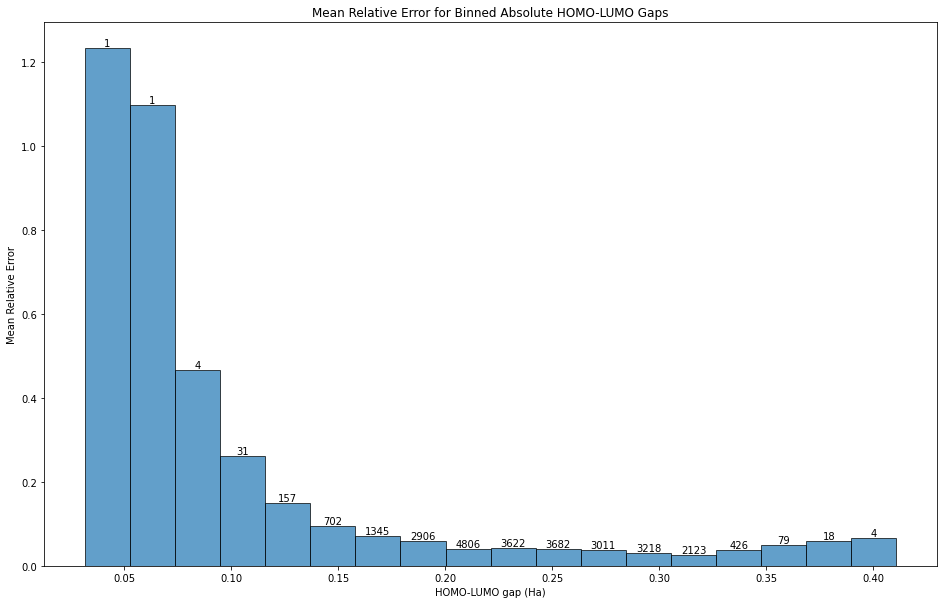

In [33]:
def autolabel(rects, counts):
    for i in range(len(rects)):
        height = rects[i].get_height()
        plt.text(rects[i].get_x() + rects[i].get_width()/2., height , '%d' % int(counts[i]), ha='center', va='bottom')

plt.figure(figsize=(16, 10))

absolute_values = sorted_list[:(len(sorted_list)-1)]
relative_errors = rel_list[:(len(sorted_list)-1)]
bins = np.linspace(min(absolute_values), max(absolute_values), 20)  
digitized = np.digitize(absolute_values, bins)
unique_values, counts = np.unique(digitized, return_counts=True)

mean_relative_errors = [np.mean(np.array(relative_errors)[digitized == i]) for i in range(1, len(bins))]
unique_values, counts = np.unique(digitized, return_counts=True)

# Create the bar plot
bars = plt.bar(bins[:-1], mean_relative_errors, width=np.diff(bins), edgecolor='black', alpha=0.7)

# Call the autolabel function to add labels above each bar
autolabel(bars, counts)

plt.xlabel('HOMO-LUMO gap (Ha)')
plt.ylabel('Mean Relative Error')
plt.title('Mean Relative Error for Binned Absolute HOMO-LUMO Gaps')

# Show the plot
plt.show()

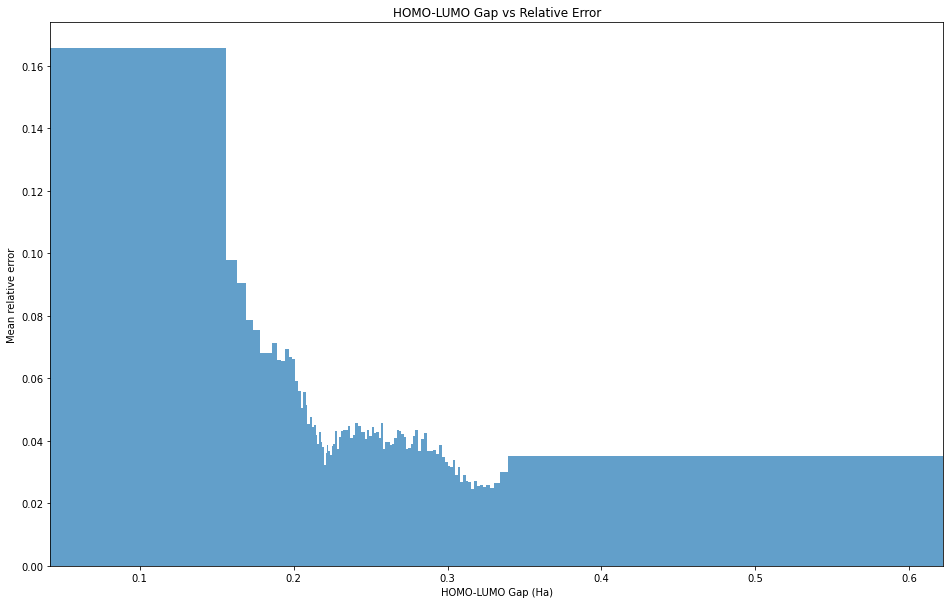

In [39]:
plt.figure(figsize=(16, 10))

homos[0] = homos[0] - min(sorted_list) 
homos[len(homos)-1] = homos[len(homos)-1] + max(sorted_list)
bar_widths = np.diff(np.concatenate([homos, [homos[-1] + (homos[-1] - homos[-2])]]))

plt.bar(homos, rels, width=bar_widths, alpha=0.7, align='edge')
plt.xlabel('HOMO-LUMO Gap (Ha)')
plt.ylabel('Mean relative error')
plt.title('HOMO-LUMO Gap vs Relative Error')
plt.xlim(min(sorted_list), max(sorted_list))
plt.show()


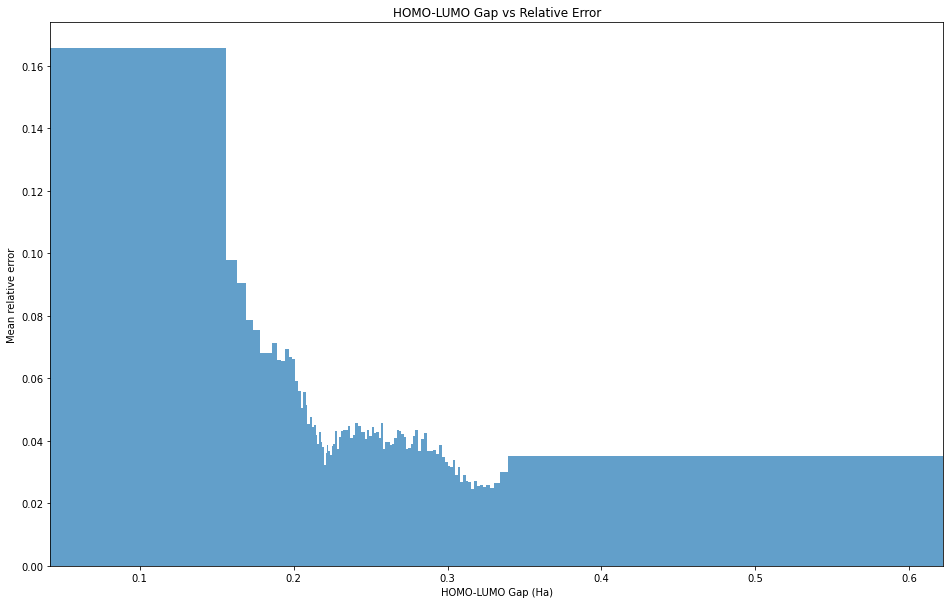

In [ ]:
plt.figure(figsize=(16, 10))


# Calculate the width of each bar based on some criteria (replace this with your own logic)
bar_widths = np.diff(np.concatenate([homos, [homos[-1] + (homos[-1] - homos[-2])]]))
homos[0] = homos[0] - min(sorted_list) 
homos[len(homos)-1] = homos[len(homos)-1] + max(sorted_list)
bar_widths[0] = homos[1] - homos[0]

# Plot the bars with variable widths
plt.bar(homos, rels, width=bar_widths, alpha=0.7, align='edge')

# Add labels and title
plt.xlabel('HOMO-LUMO Gap (Ha)')
plt.ylabel('Mean relative error')
plt.title('HOMO-LUMO Gap vs Relative Error')
plt.xlim(min(sorted_list), max(sorted_list))

# Show the plot
plt.show()